In [426]:
import numpy as np
import matplotlib.pyplot as plt

import rtree

%matplotlib inline

p = rtree.index.Property()
p.dimension = 3
idx = rtree.Index(properties=p)

# idx.insert(0, (0, 0, 0, 0, 0, 0))
# idx.insert(1, (1, 1, 1, 1, 1, 1))
# idx.insert(2, (2, 2, 2, 2, 2, 2))

In [427]:
class Node:
    def __init__(self, p, prev=None, dist=0):
        self.point = p
        self.prev = prev
        self.dist = dist
        
class Tree:
    def __init__(self):
        self.goal = np.asarray([0.5, 1])
        self.lower_bound = np.asarray((-5, -5))
        self.upper_bound = np.asarray((5, 5))
        
#         p = rtree.index.Property()
#         p.dimension = 3
#         self.idx = rtree.Index(properties=p)
        self.idx = rtree.Index()
        
        self.points = dict()
        
        self.p_idx = 0
        self.insert_node(1, 1)
    
    def insert_node(self, x, v, prev=None, dist=0):
        self.idx.insert(self.p_idx, (x, v, x, v))
        new_node = Node(np.asarray([x, v]), prev, dist)
        self.points[self.p_idx] = new_node
        self.p_idx += 1
        
        return new_node
        
    def sample(self):
        # random point
        rx, rv = np.random.rand(2) * (self.upper_bound - self.lower_bound) + self.lower_bound
        
        # nearest node `nn`
        nn_idx = self.idx.nearest([rx, rv, rx, rv])
        nn = self.points[next(nn_idx)]
        x, v = nn.point
        
        a = (np.random.rand() - 0.5) * 2
        dt = 0.1
        next_point = np.asarray((x + v * dt + dt**2 * a / 2, v + a * dt))
        
        # if new point is out of bounds
        if np.max(np.abs(next_point)) > 5:
            return None

        new_dist = nn.dist + np.linalg.norm(next_point - nn.point)
        new_node = self.insert_node(*next_point, nn, new_dist)
        
        nx, nv = new_node.point
        neighbors = self.idx.intersection([nx - 0.5, nv - 0.25, nx + 0.5, nv + 0.25])
        
        if np.linalg.norm(next_point - self.goal) < 0.2:
            return new_node
        

(-5.0, 5.0)

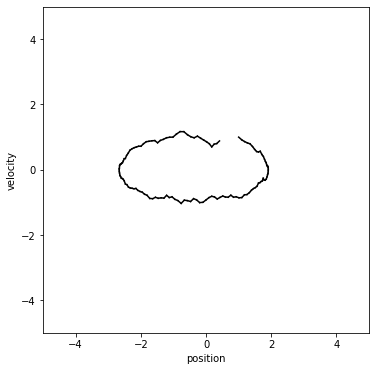

In [428]:
tree = Tree()

goal_node = None

for _ in range(10000):
    goal_node = tree.sample()
    if goal_node:
        break

# print(len(tree.points))
# print(goal_node)

fig, ax = plt.subplots(figsize=(6, 6))
ax.set_aspect('equal')


v = goal_node
while v:
    p = v.prev
    if p is None:
        break
    ax.plot([p.point[0], v.point[0]], [p.point[1], v.point[1]], '-', c='k')
    v = p

ax.set_xlabel('position')
ax.set_ylabel('velocity')

ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)

## Dynamic constraints of a point particle in 2 dimensioanl space

In [429]:
class PlaneTree:
    def __init__(self, start, goal, bounds):
        self.goal = goal
        self.lower_bound = bounds[0::2]
        self.upper_bound = bounds[1::2]
        
        p = rtree.index.Property()
        p.dimension = 4
        self.idx = rtree.Index(properties=p)
        
        self.points = dict()
        self.p_idx = 0
        
        self.insert_node(*start)
        self.min_dist = float('inf')
    
    def insert_node(self, x, y, vx, vy, prev=None, dist=0):
        self.idx.insert(self.p_idx, (x, y, vx, vy, x, y, vx, vy))
        
        nn = Node(np.asarray([x, y, vx, vy]), prev, dist)
        self.points[self.p_idx] = nn
        self.p_idx += 1
        
        return nn
    
    def sample(self):
        # random point
        rx, ry, rxv, ryv = np.random.rand(4) * (self.upper_bound - self.lower_bound) + self.lower_bound
        
        # nearest node `nn`
        nn_idx = self.idx.nearest([rx, ry, rxv, ryv, rx, ry, rxv, ryv])
        nn = self.points[next(nn_idx)]
        x, y, vx, vy = nn.point
        
        dt = 0.2
        a = (np.random.randn(2) - 0.5) * 2
        new_x, new_y = nn.point[:2] + nn.point[2:] * dt + a * dt**2 / 2
        new_xv, new_yv = nn.point[2:] + a * dt
        new_point = np.asarray([new_x, new_y, new_xv, new_yv])
        
        if any(new_point < self.lower_bound) or any(new_point > self.upper_bound):
            return None
        
        new_node = self.insert_node(*new_point, nn)
        
        dist = np.linalg.norm(new_point - self.goal)
        
        if dist < self.min_dist:
            self.min_dist = dist
            if dist < 0.2:
                return new_node
        
        return None

tree = PlaneTree(np.asarray([0, -1, 1, 0]),
                 np.asarray([0, 1, 1, 0]),
                 np.asarray([-5, 5, -5, 5, -5, 5, -5, 5]))

goal_node = None

for i in range(100000):
    if (i % 10000) == 0:
        print(f'{i:07d}, min_dist: {tree.min_dist}', end='\r')
    goal_node = tree.sample()

print('')
print(f'finished, min_dist: {tree.min_dist}')

0090000, min_dist: 0.5232206602249602
finished, min_dist: 0.5232206602249602


In [430]:
len(tree.points)

87814

In [453]:
goal_node = None

for i in range(1000000):
    if (i % 100000) == 0:
        print(f'{i:07d}, min_dist: {tree.min_dist}', end='\r')
    goal_node = tree.sample()
    if goal_node:
        break

print('')
print(f'finished, min_dist: {tree.min_dist}')

0400000, min_dist: 0.4775850640912286
finished, min_dist: 0.38234696017008146


[ 0.25266126 10.07743421  6.22792033]


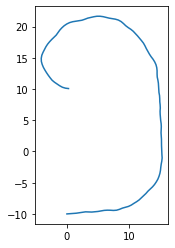

In [454]:
v = goal_node

print(goal_node.point)

xs = []
ys = []

while v:
    xs.append(v.point[0])
    ys.append(v.point[1])
    v = v.prev

fig, ax = plt.subplots()
ax.set_aspect('equal')

ax.plot(xs, ys)

## RRT for two wheel steering vehicle (Dubins car)

- it's a nonholonomic case

In [440]:
class SteerTree:
    def __init__(self):
        self.goal = np.asarray([[0, 10, 0],
                                [0, 10, np.pi * 2],
                                [0, 10, -np.pi * 2]])
        self.lower_bound = np.asarray([-20, -20, 0])
        self.upper_bound = np.asarray([20, 20, np.pi * 2])
        
        p = rtree.index.Property()
        p.dimension = 3
        self.idx = rtree.Index(properties=p)
        
        self.points = dict()
        self.p_idx = 0
        
        self.insert_node(0, -10, 0)
        self.min_dist = float('inf')
        self.min_dist_node = None
    
    def insert_node(self, x, y, th, prev=None, dist=0):
        self.idx.insert(self.p_idx, (x, y, th, x, y, th))
        
        nn = Node(np.asarray([x, y, th]), prev, dist)
        self.points[self.p_idx] = nn
        self.p_idx += 1
        
        return nn
        
    def sample(self):
        # random point
        rx, rv, rth = np.random.rand(3) * (self.upper_bound - self.lower_bound) + self.lower_bound
        
        # nearest node `nn`
        nn_idx = self.idx.nearest([rx, rv, rth, rx, rv, rth])
        nn = self.points[next(nn_idx)]
        x, y, th = nn.point
        
        # 0.5 radian / 0.5 meter is the maximum change of direction
        # that's the curvature of 1
        ds = 0.5
        new_th = (th + (np.random.rand() - 0.5) * 0.5)
        new_x, new_y = x + ds * np.cos((th + new_th) / 2), y + ds * np.sin((th + new_th)/2)
        new_th = new_th % (np.pi * 2)
        new_point = np.asarray([new_x, new_y, new_th])
        
        if np.max(np.abs(new_point[:2])) > 30:
            return None

        new_node = self.insert_node(*new_point, nn)
        
        dist = np.min(np.linalg.norm((self.goal - new_point) * np.asarray([1, 1, 5]), axis=1))
        if dist < self.min_dist:
            self.min_dist = dist
            self.min_dist_node = new_node
            if dist < 0.5:
                return new_node
        
        return None
        

tree = SteerTree()

goal_node = None
max_iter = 100000

for i in range(max_iter):
    goal_node = tree.sample()
    if (i % 10000 == 0):
        print(f'{i:07d}/{max_iter}, min_dist: {tree.min_dist}', end='\r')
    if goal_node:
        break

# print(goal_node, goal_node.prev)
print('')
print('min_dist', tree.min_dist)


# print(len(tree.points.items()))
# for k, v in tree.points.items():
#     p = v.prev
#     if p is None:
#         continue
    
#     ax.plot([p.point[0], v.point[0]], [p.point[1], v.point[1]])


0090000/100000, min_dist: 0.8354285918126474
min_dist 0.8354285918126474


### more samples

In [443]:
goal_node = None
max_iter = 100000

for i in range(max_iter):
    goal_node = tree.sample()
    if (i % 10000 == 0):
        print(f'{i:07d}/{max_iter}, min_dist: {tree.min_dist}', end='\r')
    if goal_node:
        break

0.4775850640912286


(-18.0, 23.0)

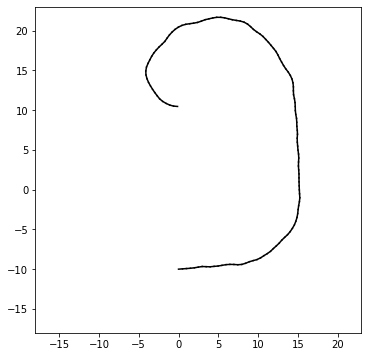

In [452]:
# print(tree.min_dist, goal_node.point)

fig, ax = plt.subplots(figsize=(6, 6))
ax.set_aspect('equal')

print(tree.min_dist)
v = tree.min_dist_node

while v:
    p = v.prev
    if p is None:
        break
    ax.plot([p.point[0], v.point[0]], [p.point[1], v.point[1]], '-', c='k')
    v = p

ax.set_xlim(-18, 23)
ax.set_ylim(-18, 23)

### minimum RRT paths for 10 cases

In [446]:
paths = []

for path_idx in range(10):
    tree = SteerTree()

    goal_node = None
    max_iter = 1000000

    for i in range(max_iter):
        goal_node = tree.sample()
        if (i % 10000 == 0):
            print(f'{i:7d}/{max_iter}, min_dist: {tree.min_dist}', end='\r')
        if goal_node:
            break

    # print(goal_node, goal_node.prev)
    print('')
    print('min_dist', tree.min_dist)
    
    if goal_node:
        v = goal_node

        path = []
        
        while v:
            path.append(v.point)
            v = v.prev
        
        paths.append(path)
        print(path_idx, len(path))
    

 110000/1000000, min_dist: 1.2705994508318763
min_dist 0.34320342466849113
0 97
 560000/1000000, min_dist: 0.5340316406481372
min_dist 0.35144599582058883
1 101
 110000/1000000, min_dist: 1.1658571945223675
min_dist 0.2786484615461695
2 54
 360000/1000000, min_dist: 0.5641539638449734
min_dist 0.460444898920453
3 135
 210000/1000000, min_dist: 0.7535048313548258
min_dist 0.4310395702307139
4 122
 170000/1000000, min_dist: 0.5230696199345278
min_dist 0.08919089880662004
5 93
 250000/1000000, min_dist: 0.6861535799495886
min_dist 0.35892642353650334
6 129
 260000/1000000, min_dist: 0.7696197371265845
min_dist 0.3704644419788744
7 101
 460000/1000000, min_dist: 0.5709190780228791
min_dist 0.47261625699883053
8 140
 330000/1000000, min_dist: 0.7179441393387666
min_dist 0.4775850640912286
9 134


(-16.0, 25.0)

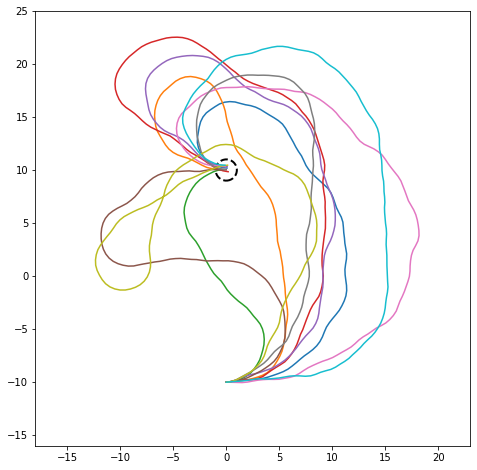

In [449]:
from matplotlib.patches import Circle


fig, ax = plt.subplots(figsize=(8, 8))

ax.set_aspect('equal')

for path in paths:
    ax.plot([x[0] for x in path], [x[1] for x in path])


c = Circle((0, 10), radius=1, ec='k', fc='None', linestyle='--', lw=2)
ax.add_patch(c)

ax.set_xlim(-18, 23)
ax.set_ylim(-16, 25)

In [423]:
print(f'{10:6d}')

    10


In [412]:
%load_ext cython

In [419]:
%%cython
def myfunc():
    cdef int i
    cdef long long j
    
    j = 0
    
    for i in range(1000000):
        j += 1
    
    return j

In [420]:
%timeit myfunc()

27 ns ± 0.601 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


In [421]:
def slow_myfunc():
    j = 0
    for i in range(1000000):
        j += 1
    return j

In [422]:
%timeit slow_myfunc()

31.7 ms ± 593 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Bidirection RRT for a Dubins car

In [ ]:
class SteerTree:
    def __init__(self, start, end):
        dth = np.zeros(3, 3)
        dth[:, -1] = [-np.pi * 2, 0, np.pi *2]
        self.start = start + dth
        self.end = end + dth
        
        self.lower_bound = np.asarray([-20, -20, 0])
        self.upper_bound = np.asarray([20, 20, np.pi * 2])
        
        p = rtree.index.Property()
        p.dimension = 3
        self.idx = [rtree.Index(properties=p), rtree.Index(properties.p)]
                
        self.points = [dict(), dict()]
        self.p_idx = [0, 0]
        
        self.insert_node(0, 0, -10, 0)
        
        self.min_dist = [float('inf'), float('inf')]
        self.sel_idx = 0
    
    def insert_node(self, idx, x, y, th, prev=None, dist=0):
        self.idx[idx].insert(self.p_idx, (x, y, th, x, y, th))
        
        nn = Node(np.asarray([x, y, th]), prev, dist)
        self.points[idx][self.p_idx] = nn
        self.p_idx[idx] += 1
        
        return nn
        
    def sample(self):
        idx = self.idx[self.sel_idx]
        points = self.points[self.sel_idx]
        
        
        # random point
        rx, rv, rth = np.random.rand(3) * (self.upper_bound - self.lower_bound) + self.lower_bound
        
        # nearest node `nn`
        nn_idx = idx.nearest([rx, rv, rth, rx, rv, rth])
        nn = points[next(nn_idx)]
        x, y, th = nn.point
        
        ds = 0.5
        new_th = (th + (np.random.rand() - 0.5))
        new_x, new_y = x + ds * np.cos((th + new_th) / 2), y + ds * np.sin((th + new_th)/2)
        new_th = new_th % (np.pi * 2)
        new_point = np.asarray([new_x, new_y, new_th])
        
        if np.max(np.abs(new_point[:2])) > 30:
            return None

        new_node = insert_node(*new_point, nn)
        
        dist = np.min(np.linalg.norm((self.goal - new_point) * np.asarray([1, 1, 5]), axis=1))
        if dist < self.min_dist:
            self.min_dist = dist
            if dist < 0.5:
                return new_node
        
        return None